# Tutorial of implementing Class activation map
간단한 CNN (with Global Average Pooling)을 mnist clutter 데이터에 대해서 학습하고 임의의 mnist clutter 데이터 중 하나를 예측하고 Class Activation Map을 그리는 예제, mnist clutter 데이터는 기존의 mnist 데이터가 (28,28,1)의 image 였던 반면에, (40,40,1)의 image이며 아래의 그림과 같이 특정 숫자의 image에 대해서 noise가 섞여있는 이미지  

구조 : Conv-Conv-Max_pool-Conv-Conv-Max_pool-Conv-Conv-Global_average_pool-fully_connected  
(activation function으로 relu를 활용하며, relu를 통과하기전 batch normalization 활용)

* 논문 : http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf

![Alt text](http://i.imgur.com/fTtJIFP.png)

### Setup

In [1]:
import os, sys
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

### Load Mnist clutter dataset

In [2]:
mnist = np.load('./data/MNIST_clutter/mnist_sequence1_sample_5distortions5x5.npz')

In [3]:
tr_x = mnist['X_train']
tr_y = mnist['y_train']
val_x = mnist['X_valid']
val_y = mnist['y_valid']
ts_x = mnist['X_test']
ts_y = mnist['y_test']

In [4]:
# One-hot representation function
def one_hot(label):
    enc = OneHotEncoder()
    enc.fit(label)
    res = enc.transform(label).toarray()
    return res

In [5]:
# transform
tr_y = one_hot(tr_y)
val_y = one_hot(val_y)
ts_y = one_hot(ts_y)

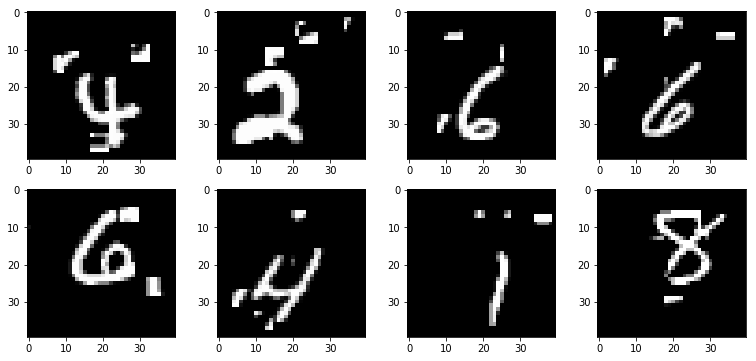

In [6]:
# Visualize mnist cluster dataset
tmp = tr_x.reshape(-1,40,40)
indices = np.random.randint(0, high = tmp.shape[0], size = 8)
fig = plt.figure(figsize = (15,6))
fig.subplots_adjust(right=0.8)
for i, index in enumerate(indices):
    fig.add_subplot(2,4,i+1)
    plt.imshow(tmp[index], cmap = 'gray')    

### Define CNN

In [7]:
class CNN:
    def __init__(self, activation_fn = tf.nn.relu,
                 initializer = tf.contrib.slim.xavier_initializer_conv2d(),
                 l2_scale = .001):
        
        with tf.variable_scope('input_layer'):
            self._x = tf.placeholder(dtype = tf.float32, shape = [None, 1600])
            self._ximg = tf.reshape(tensor = self._x, shape = [-1, 40, 40, 1])
            self._y = tf.placeholder(dtype = tf.float32, shape = [None, 10])
            self._training = tf.placeholder(dtype = tf.bool)
            self._keep_prob = tf.placeholder(dtype = tf.float32)
            
        with tf.contrib.slim.arg_scope([tf.contrib.slim.conv2d], kernel_size = [3,3], padding = 'SAME',
                                       weights_initializer = initializer,
                                       weights_regularizer = tf.contrib.slim.l2_regularizer(scale = l2_scale),
                                       stride = 1):
        
            with tf.variable_scope('conv_layer1'):
                _conv = tf.contrib.slim.conv2d(inputs = self._ximg, num_outputs = 32)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                _relu = tf.nn.relu(features = _conv)
            
            with tf.variable_scope('conv_layer2'):
                _conv = tf.contrib.slim.conv2d(inputs = _conv, num_outputs = 32)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                _relu = tf.nn.relu(features = _conv)
            
            with tf.variable_scope('max_pool1'):
                _pool = tf.contrib.slim.max_pool2d(inputs = _relu, kernel_size = [2,2], stride = 2)
            
            with tf.variable_scope('conv_layer3'):
                _conv = tf.contrib.slim.conv2d(inputs = _pool, num_outputs = 32)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)   
                _relu = tf.nn.relu(features = _conv)
            
            with tf.variable_scope('conv_layer4'):
                _conv = tf.contrib.slim.conv2d(inputs = _relu, num_outputs = 32)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                _relu = tf.nn.relu(features = _conv)
                
            with tf.variable_scope('max_pool2'):
                _pool = tf.contrib.slim.max_pool2d(inputs = _relu, kernel_size = [2,2], stride = 2)

            with tf.variable_scope('conv_layer5'):
                _conv = tf.contrib.slim.conv2d(inputs = _pool, num_outputs = 32)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                _relu = tf.nn.relu(features = _conv)
            
            with tf.variable_scope('conv_layer6'):
                _conv = tf.contrib.slim.conv2d(inputs = _relu, num_outputs = 32)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                self._relu = tf.nn.relu(features = _conv)
            
            with tf.variable_scope('global_pool'):
                _pooled = tf.contrib.slim.avg_pool2d(inputs = self._relu, kernel_size = [10,10], stride = 10)
                _pooled = tf.contrib.slim.flatten(inputs = _pooled)
                _pooled = tf.contrib.slim.dropout(inputs = _pooled, keep_prob = self._keep_prob)
                
        with tf.variable_scope('output_layer'):
            self._score = tf.contrib.slim.fully_connected(inputs = _pooled, num_outputs = 10, activation_fn = None,
                                                          weights_initializer = tf.contrib.slim.xavier_initializer(uniform = False),
                                                          weights_regularizer = tf.contrib.slim.l2_regularizer(scale=l2_scale))
        with tf.variable_scope('loss'):
            _ce_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self._y, logits = self._score))
            _reg_term = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
            self._total_loss = _ce_loss + _reg_term
                
        self._update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        with tf.variable_scope('predict'):
            self._prediction = tf.nn.softmax(logits = self._score)
        
    def predict(self, sess, x_data, training = False, keep_prob = 1.):
        feed_predict = {self._x : x_data, self._training : training, self._keep_prob : keep_prob}
        return sess.run(self._prediction, feed_dict = feed_predict)
    
    def extract_featuremap(self, sess, x_data, training = False, keep_prob = 1.):
        feed_featuremap = {self._x : x_data, self._training : training, self._keep_prob : keep_prob}
        return sess.run(self._relu, feed_dict = feed_featuremap)

### Define Solver class

In [8]:
class Solver:
    def __init__(self, model, optimizer = tf.train.AdamOptimizer, var_list = None):
        self._model = model
        self._lr = tf.placeholder(dtype = tf.float32)
        self._optimizer = optimizer(learning_rate = self._lr)
        
        # Solver class는 model class로부터 생성된 instance를 input으로 받음. model class에서 저장한 객체변수를 아래와 같이 활용
        with tf.control_dependencies(self._model._update_ops):
            self._training_op = self._optimizer.minimize(loss = self._model._total_loss, var_list = var_list)
    
    def train(self, sess, x_data, y_data, lr, training = True, keep_prob = .5):
        feed_train = {self._model._x : x_data, self._model._y : y_data, self._lr : lr,
                      self._model._training : training, self._model._keep_prob : keep_prob}
        return sess.run(fetches = [self._training_op, self._model._total_loss], feed_dict = feed_train)
            
    def evaluate(self, sess, x_data, y_data, training = False, keep_prob = 1.):
        feed_loss = {self._model._x : x_data, self._model._y : y_data, self._model._training : training,
                     self._model._keep_prob : keep_prob}
        return sess.run(fetches = self._model._total_loss, feed_dict = feed_loss)

### Generate CNN model and Solvers

In [9]:
sess = tf.Session()
clutter_classifier = CNN()

In [10]:
adam_solver = Solver(model = clutter_classifier)

### Training 

In [11]:
# Hyper-parameters
batch_size = 50
n_epochs = 10
tr_loss_history = []
val_loss_history = []

In [12]:
sess.run(tf.global_variables_initializer())

In [13]:
for epoch in range(n_epochs):
    avg_tr_loss = 0
    avg_val_loss = 0
    total_batch = int(tr_x.shape[0] / batch_size)
    
    for step in range(total_batch):
        tr_indices = np.random.choice(np.arange(tr_x.shape[0]), size = batch_size, replace=False)
        val_indices = np.random.choice(np.arange(val_x.shape[0]), size = batch_size, replace=False)
        batch_xs = tr_x[tr_indices]
        batch_ys = tr_y[tr_indices]
        val_xs = val_x[val_indices]
        val_ys = val_y[val_indices]
        _, tr_loss = adam_solver.train(sess = sess, x_data = batch_xs, y_data = batch_ys, lr = 1e-3)
        val_loss = adam_solver.evaluate(sess = sess, x_data = val_xs, y_data = val_ys)

        avg_tr_loss += tr_loss / total_batch
        avg_val_loss += val_loss / total_batch
        if step % 50 == 0:
            print('step : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(step, tr_loss, val_loss))

    print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch, avg_tr_loss, avg_val_loss))
    tr_loss_history.append(avg_tr_loss)
    val_loss_history.append(avg_val_loss)

step :   0, tr_loss : 2.398, val_loss : 2.391
step :  50, tr_loss : 1.903, val_loss : 2.039
step : 100, tr_loss : 1.560, val_loss : 1.275
step : 150, tr_loss : 1.139, val_loss : 1.057
epoch :   0, tr_loss : 1.587, val_loss : 1.524
step :   0, tr_loss : 1.057, val_loss : 0.844
step :  50, tr_loss : 0.895, val_loss : 0.680
step : 100, tr_loss : 0.647, val_loss : 0.390
step : 150, tr_loss : 0.731, val_loss : 0.407
epoch :   1, tr_loss : 0.764, val_loss : 0.572
step :   0, tr_loss : 0.669, val_loss : 0.455
step :  50, tr_loss : 0.504, val_loss : 0.516
step : 100, tr_loss : 0.560, val_loss : 0.227
step : 150, tr_loss : 0.487, val_loss : 0.416
epoch :   2, tr_loss : 0.532, val_loss : 0.361
step :   0, tr_loss : 0.411, val_loss : 0.239
step :  50, tr_loss : 0.362, val_loss : 0.378
step : 100, tr_loss : 0.429, val_loss : 0.251
step : 150, tr_loss : 0.340, val_loss : 0.278
epoch :   3, tr_loss : 0.420, val_loss : 0.297
step :   0, tr_loss : 0.305, val_loss : 0.183
step :  50, tr_loss : 0.243, v

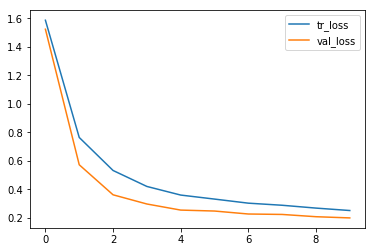

In [14]:
plt.plot(tr_loss_history, label = 'tr_loss')
plt.plot(val_loss_history, label = 'val_loss')
plt.legend()

In [15]:
hat = clutter_classifier.predict(sess = sess, x_data = ts_x)

In [16]:
print('Accuracy : {:.2%}'.format(np.mean(np.argmax(hat, axis = 1) == np.argmax(ts_y, axis = 1))))

Accuracy : 97.50%


### Class Activation Map

In [17]:
weights = sess.run(tf.get_collection(tf.GraphKeys.MODEL_VARIABLES, scope = 'output_layer')[0])
def cam(featuremap, weights, pred_class):
    pred_weights = weights[:,pred_class]
    output = np.zeros(featuremap.shape[1:3])
    
    for channel in range(weights.shape[0]):
        output += pred_weights[channel] * featuremap[0,:,:,channel] 
    output /= weights.shape[0]
    output = resize(output, output_shape = [40,40], mode = 'reflect')
    output = (output - np.min(output)) / (np.max(output) - np.min(output))
    plt.imshow(output, cmap = 'jet', interpolation = 'bilinear')

Text(0.5,1,'0 is True label, 0 is prediction')

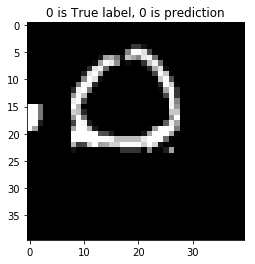

In [18]:
target_index = np.random.choice(np.arange(ts_y.shape[0]), size = 1)
hat = clutter_classifier.predict(sess = sess, x_data = ts_x[target_index])
plt.imshow(ts_x[target_index].reshape(40,40), cmap = 'gray')
plt.title('{} is True label, {} is prediction'.format(np.argmax(ts_y[target_index]),np.argmax(hat)))

In [19]:
featuremap = clutter_classifier.extract_featuremap(sess = sess, x_data = ts_x[target_index])

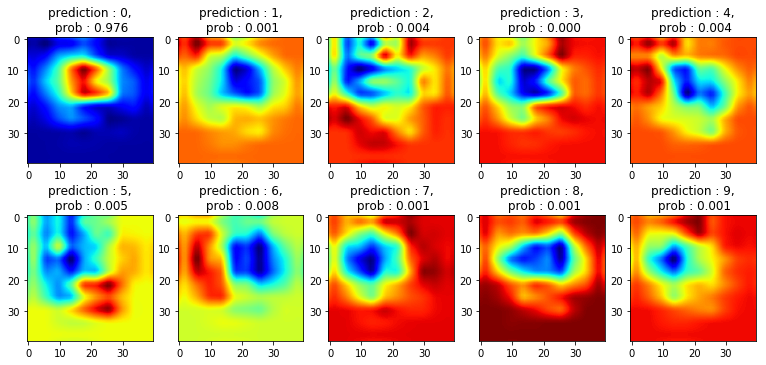

In [20]:
fig = plt.figure(figsize = (15, 6))
fig.subplots_adjust(right = .8)
for pred_class, pred_prob in enumerate(hat.flatten()):
    fig.add_subplot(2,5, pred_class + 1)
    cam(featuremap, weights, pred_class)
    plt.title('prediction : {},\n prob : {:.3f}'.format(pred_class, pred_prob))